## Useful librairies

To acces webcam stream, filter images, etc

In [ ]:
!pip3 install bokeh

In [ ]:
!pip3 install opencv-python

In [ ]:
!pip3 install opencv_contrib_python

# Initialization and path planning

In [3]:
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

import cv2
import time

from bokeh.plotting import figure
from bokeh.io import output_notebook, show, push_notebook
from tqdm import tqdm

import IPython.display as Disp
from ipywidgets import widgets
%matplotlib inline

## Take environment picture

Take photo of the environement with the global obstacles without Thymio

__J'ai mis une photo _environment.png_ en example__ Donc la cellule d'après n'est pas obligatoire, c'est juste un example de comment ouvrir un webcam stream pour donner une idée

In [2]:
## Open camera stream and take a photo

# scale=150
# cam = cv2.VideoCapture(0) #Open webcam stream
# while True:
#                 ret_val, image = cam.read() #Read webcam stream
#                 #get the webcam size
#                 height, width, channels = image.shape
#                 #prepare the crop
#                 centerX,centerY=int(height/2),int(width/2)
#                 radiusX,radiusY= int(scale*height/100),int(scale*width/100)

#                 minX,maxX=centerX-radiusX,centerX+radiusX
#                 minY,maxY=centerY-radiusY,centerY+radiusY

#                 cropped = image[minX:maxX, minY:maxY]
#                 resized_cropped = cv2.resize(cropped, (width, height)) 

#                 cv2.imshow('Webcam', resized_cropped)
#                 if cv2.waitKey(1) == 27: 
#                     break  # Press "esc" (or "echap") to quit

#                 # Zoom Out
#                 if cv2.waitKey(1) == ord('m'): 
#                     scale += 5  # +5
#                     print(scale)
#                     if (radiusX >= height or radiusY >= width):
#                         radiusX=height
#                         radiusY=width
                        
#                 #Zoom In    
#                 if cv2.waitKey(1) == ord('p'): 
#                     scale -= 5  # +5
#                     print(scale)
#                     if (radiusX >= height or radiusY >= width):
#                         radiusX=height
#                         radiusY=width
# showpic = cv2.imwrite("environment.png",image)
# print(showpic)
# #Close webcam stream (super important to get to this line, otherwise impossible to run twice this cell)
# cam.release() 
# #Close window generated by python
# cv2.destroyAllWindows()


True


## Load and rescale environment picture

Load photo of environement and downsize it. Quality reduced but easier to process.

Image Loaded
Original size (480, 640, 3)
Scaled size (96, 128, 3)
Width 128 Height 96


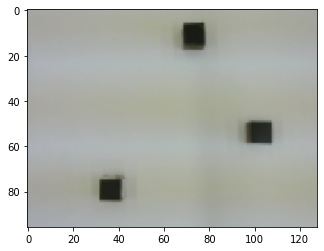

In [4]:
img = cv2.imread('environment.png', cv2.IMREAD_COLOR) # Read picture file

# If the image path is wrong, the resulting img will be none
if img is None:
    print('Image not found in the directory')
else:
    print('Image Loaded')
    
print('Original size',img.shape)
height=img.shape[0]
width=img.shape[1]

#Downsize  image to prevent from having an occupancy grid to large
scale_factor = 1/5;
width = int(img.shape[1]*scale_factor)
height = int(img.shape[0]*scale_factor)
dimension = (width,height)
resized = cv2.resize(img,dimension, interpolation = cv2.INTER_AREA) 
img = resized
print('Scaled size',img.shape)
print('Width',width,'Height',height)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

## Grid function

In [4]:
def create_empty_plot(max_valX=width,max_valY=height):
    """
    Helper function to create a figure of the desired dimensions & grid
    
    :param max_val: dimension of the map along the x and y dimensions
    :return: the fig and ax objects.
    """
    fig, ax = plt.subplots(figsize=(7,7))
    
    major_ticksX = np.arange(0, max_valX+1, 10)
    minor_ticksX = np.arange(0, max_valX+1, 1)
    major_ticksY = np.arange(0, max_valY+1, 5)
    minor_ticksY = np.arange(0, max_valY+1, 1)
    ax.set_xticks(major_ticksX)
    ax.set_xticks(minor_ticksX, minor=True)
    ax.set_yticks(major_ticksY)
    ax.set_yticks(minor_ticksY, minor=True)
    ax.grid(which='minor', alpha=0.2)
    ax.grid(which='major', alpha=0.5)
    ax.set_ylim([max_valY+1,-1])
    ax.set_xlim([-1,max_valX+1])
    ax.grid(True)
    
    return fig, ax

## Global Thresholding + Obstacle Dilation

First use global threshold to discriminate the obstacles. The histogram of the image is used to determine  Then, use dilation to grow them in order to take into account thymio's size.

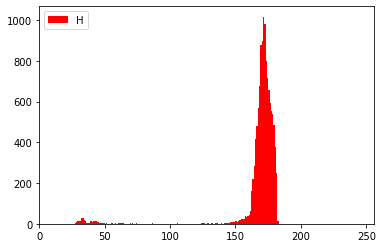

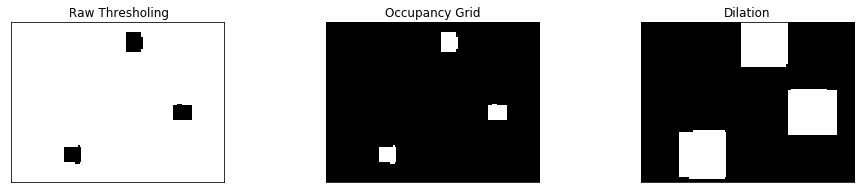

In [5]:
#Filtering
bilateral = cv2.bilateralFilter(img,9,75,75)
bw_img = cv2.cvtColor(bilateral, cv2.COLOR_BGR2GRAY)

#Histogram
#Display histogram to asses the best threshold
#/!\Higly depend of the light conditions of the environement /!\
plt.figure()
plt.hist(bw_img.flatten(),256,[0,256], color = 'r')
plt.xlim([0,256])
plt.legend(('Histogram'), loc = 'upper left')
plt.show()

# Thresholding
# As the method is depend of the light conditions,
# the threshold bounds must be defined by hand regarding the histogram
LOW_threshold = 100
UP_threshold = 150

ret1,th1 = cv2.threshold(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY),LOW_threshold,UP_threshold,cv2.THRESH_BINARY)

# Dilation
occupancy_grid = th1.copy()
occupancy_grid[th1==0] = 1
occupancy_grid[th1==UP_threshold] = 0

size_kernel = 7 #Tune obstacle size changing
kernel = np.ones((size_kernel,size_kernel),np.uint8)
dilation = cv2.dilate(occupancy_grid,kernel,iterations = 3)


# Plot of both results
titles=[' Raw Thresholing','Occupancy Grid', 'Dilation']
images=[th1,occupancy_grid, dilation]

plt.figure(figsize=(16,10))

for i in range(len(images)):
    plt.subplot(3,3,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()

## Occupancy Grid Generation

Use previous results to generate the occupancy grid

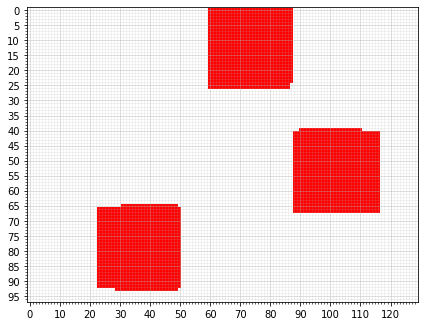

In [6]:
fig, ax = create_empty_plot(width,height)
np.random.seed(0) 
#Free space = white, Obstacles = red
cmap = colors.ListedColormap(['white', 'red'])

occupancy_grid = dilation.copy() #Update occupancy grid with delated obstacles

# Displaying the map
ax.imshow(occupancy_grid, cmap=cmap)

## A*

For path planning, the A* algorithm is implemented. As the occupancy grid is not to large it will not take long to compute the desired path.
The following implementation is based on this [GitHub](https://github.com/richardos/occupancy-grid-a-star/blob/master/a_star.py) and this [pseudo-code](https://en.wikipedia.org/wiki/A*_search_algorithm).

In [7]:
def _get_movements_4n():
    """
    Get all possible 4-connectivity movements.
    :return: list of movements with cost [(dx, dy, movement_cost)]
    """
    return [(1, 0, 1.0),
            (0, 1, 1.0),
            (-1, 0, 1.0),
            (0, -1, 1.0)]

def _get_movements_8n():
    """
    Get all possible 8-connectivity movements. Equivalent to get_movements_in_radius(1).
    :return: list of movements with cost [(dx, dy, movement_cost)]
    """
    s2 = math.sqrt(2)
    return [(1, 0, 1.0),
            (0, 1, 1.0),
            (-1, 0, 1.0),
            (0, -1, 1.0),
            (1, 1, s2),
            (-1, 1, s2),
            (-1, -1, s2),
            (1, -1, s2)]

def reconstruct_path(cameFrom, current):
    """
    Recurrently reconstructs the path from start node to the current node
    :param cameFrom: map (dictionary) containing for each node n the node immediately 
                     preceding it on the cheapest path from start to n 
                     currently known.
    :param current: current node (x, y)
    :return: list of nodes from start to current node
    """
    total_path = [current]
    while current in cameFrom.keys():
        # Add where the current node came from to the start of the list
        total_path.insert(0, cameFrom[current]) 
        current=cameFrom[current]
    return total_path

def A_Star(start, goal, h, coords, occupancy_grid, max_valX=width, max_valY=height, movement_type="4N"):
    """
    A* for 2D occupancy grid. Finds a path from start to goal.
    h is the heuristic function. h(n) estimates the cost to reach goal from node n.
    :param start: start node (x, y)
    :param goal_m: goal node (x, y)
    :param occupancy_grid: the grid map
    :param movement: select between 4-connectivity ('4N') and 8-connectivity ('8N', default)
    :return: a tuple that contains: (the resulting path in meters, the resulting path in data array indices)
    """
    # For some reason this error occurs any time so I just commented it
    #for point in [start, goal]:
        #for coord in point:
            #assert coord>=0 and coord<max_valX, "startX or endX goal not contained in the map"
            #assert coord>=0 and coord<max_valY, "startY or endY goal not contained in the map"
            
    
    # check if start and goal nodes correspond to free spaces
    if occupancy_grid[start[0], start[1]]:
        raise Exception('Start node is not traversable')

    if occupancy_grid[goal[0], goal[1]]:
        raise Exception('Goal node is not traversable')
    
    # get possible movements
    if movement_type == '4N':
        movements = _get_movements_4n()
    elif movement_type == '8N':
        movements = _get_movements_8n()
    else:
        raise ValueError('Unknown movement')
    
    
    # The set of visited nodes that need to be (re-)expanded, i.e. for which the neighbors need to be explored
    # Initially, only the start node is known.
    openSet = [start]
    
    # The set of visited nodes that no longer need to be expanded.
    closedSet = []

    # For node n, cameFrom[n] is the node immediately preceding it on the cheapest path from start to n currently known.
    cameFrom = dict()

    # For node n, gScore[n] is the cost of the cheapest path from start to n currently known.
    gScore = dict(zip(coords, [np.inf for x in range(len(coords))]))
    gScore[start] = 0

    # For node n, fScore[n] := gScore[n] + h(n). map with default value of Infinity
    fScore = dict(zip(coords, [np.inf for x in range(len(coords))]))
    fScore[start] = h[start]

    # while there are still elements to investigate
    while openSet != []:
        
        #the node in openSet having the lowest fScore[] value
        fScore_openSet = {key:val for (key,val) in fScore.items() if key in openSet}
        current = min(fScore_openSet, key=fScore_openSet.get)
        del fScore_openSet
        
        #If the goal is reached, reconstruct and return the obtained path
        if current == goal:
            return reconstruct_path(cameFrom, current), closedSet

        openSet.remove(current)
        closedSet.append(current)
        
        #for each neighbor of current:
        for dx, dy, deltacost in movements:
            
            neighbor = (current[0]+dx, current[1]+dy)
            
            # if the node is not in the map, skip
            if (neighbor[0] >= occupancy_grid.shape[0]) or (neighbor[1] >= occupancy_grid.shape[1]) or (neighbor[0] < 0) or (neighbor[1] < 0):
                continue
            
            # if the node is occupied or has already been visited, skip
            if (occupancy_grid[neighbor[0], neighbor[1]]) or (neighbor in closedSet): 
                continue
                
            # d(current,neighbor) is the weight of the edge from current to neighbor
            # tentative_gScore is the distance from start to the neighbor through current
            tentative_gScore = gScore[current] + deltacost
            
            if neighbor not in openSet:
                openSet.append(neighbor)
                
            if tentative_gScore < gScore[neighbor]:
                # This path to neighbor is better than any previous one. Record it!
                cameFrom[neighbor] = current
                gScore[neighbor] = tentative_gScore
                fScore[neighbor] = gScore[neighbor] + h[neighbor]

    # Open set is empty but goal was never reached
    print("No path found to goal")
    return [], closedSet

### Call A*

Compute the path of Thymio's center of rotation. Since the obstacles are enlarged compare to reality Thymio is able to pass next to global obstacles without touching them. 

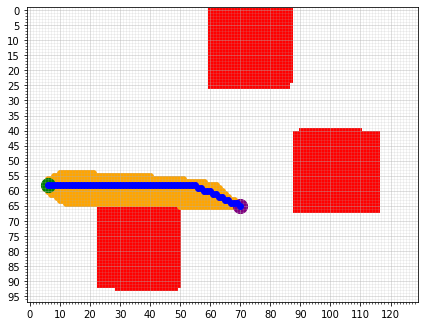

In [8]:
def trackertoastar():
    scaletracker = 1/5
    %store -r posThym
    x = int(round(scaletracker*posThym[0],2))
    y = int(round(96- scaletracker*posThym[1],2))
    theta = round((posThym[2]),2)
    astarpos = (x,y)
    return astarpos
# Define the start and end goal
start = trackertoastar()
goal = (70,65)

# List of all coordinates in the grid
x,y = np.mgrid[0:width:1, 0:height:1]
pos = np.empty(x.shape + (2,))
pos[:, :, 0] = x; pos[:, :, 1] = y
pos = np.reshape(pos, (x.shape[0]*x.shape[1], 2))
coords = list([(int(x[0]), int(x[1])) for x in pos])

# Define the heuristic, here = distance to goal ignoring obstacles
h = np.linalg.norm(pos - goal, axis=-1)
h = dict(zip(coords, h))

# Run the A* algorithm
path, visitedNodes = A_Star(start, goal, h, coords, occupancy_grid.transpose(), movement_type="8N")
path = np.array(path).reshape(-1, 2).transpose()

visitedNodes = np.array(visitedNodes).reshape(-1, 2).transpose()

# Displaying the map
fig_astar, ax_astar = create_empty_plot(width,height)
ax_astar.imshow(occupancy_grid, cmap=cmap)

# Plot the best path found and the list of visited nodes
ax_astar.scatter(visitedNodes[0], visitedNodes[1], marker="o", color = 'orange');
ax_astar.plot(path[0], path[1], marker="o", color = 'blue');
ax_astar.scatter(start[0], start[1], marker="o", color = 'green', s=200);
ax_astar.scatter(goal[0], goal[1], marker="o", color = 'purple', s=200);

In [9]:
scale = 0.05/10 #TO CALIBRATE AT THE BEGINNING
def astartoglobal(xastar,yastar):
    xglobal =round(scale*xastar,2)
    yglobal =round(scale*yastar,2)
    return xglobal,yglobal

In [10]:
x=path[0]
y=path[1]

targets=[]
for i in range(0,len(x)):
    temp=[round(x[i]*scale,3),round(y[i]*scale,3)]
    targets.append(temp)
targets=targets[0::4]
print(targets)
targets=targets[5:]
print(targets)

[[0.03, 0.29], [0.05, 0.29], [0.07, 0.29], [0.09, 0.29], [0.11, 0.29], [0.13, 0.29], [0.15, 0.29], [0.17, 0.29], [0.19, 0.29], [0.21, 0.29], [0.23, 0.29], [0.25, 0.29], [0.27, 0.29], [0.29, 0.3], [0.31, 0.305], [0.33, 0.315], [0.35, 0.325]]
[[0.13, 0.29], [0.15, 0.29], [0.17, 0.29], [0.19, 0.29], [0.21, 0.29], [0.23, 0.29], [0.25, 0.29], [0.27, 0.29], [0.29, 0.3], [0.31, 0.305], [0.33, 0.315], [0.35, 0.325]]


__Note du Max de MA3__ : on avait tenté un PID mais on s'est rendu compte trop tard qu'on s'était emmelé les pinceaux donc la partie qui suit est pas dingue mais je la laisse des fois que ^^'

# 2. Control Thymio along the path

A PID controller is used to keep Thymio on the path. Its position is estimated through a kalman filter which uses the odometry and vision tracking. The latter is performed with a webcam placed above the environment.

## Connect Thymio to python

In [11]:
#Thymio.py has to be in the directory
from Thymio import Thymio
import sys
print(sys.executable)

c:\users\maxime\appdata\local\programs\python\python37\python.exe


In [12]:
#Do not execute this command twice otherwise you will get an error
th = Thymio.serial(port="\\.\COM4", refreshing_rate=0.1)

In [13]:
def distance(p1,p2):
    dist = math.sqrt(math.pow((p1[0]-p2[0]),2)+math.pow((p1[1]-p2[1]),2))
    return dist

def clockwise():
    th.set_var("motor.left.target", 2**16-110)
    th.set_var("motor.right.target", 100)
    return
    
def anticlockwise():
    th.set_var("motor.left.target", 110)
    th.set_var("motor.right.target", 2**16-100)
    return

#This function aims to retrieve and convert the tracker coordinates into real ones in meter
def posthymtoglobal():
    %store -r posThym #retreive position in tracker map from Tracking notebook
    pos = trackertoglobal(posThym[0],posThym[1])
    globalpos= [pos[0],pos[1],-round((posThym[2]),2)]
    return globalpos

scale = 0.05/10
def astartoglobal(xastar,yastar):
    xglobal =round(scale*xastar,2)
    yglobal =round(scale*yastar,2)
    return xglobal,yglobal



def trackertoglobal(xtracker,ytracker):
    scaletracker = 1/5
    xglobal = round(scale*scaletracker*xtracker,2)
    #As the y axis of the occupancy grid is oriented downwards
    #the y axis of the tracker has to be converted the same way
    yglobal = round(scale*(scaletracker*ytracker),2) 
    return xglobal,yglobal

In [14]:
def angle(p1,p2):
    d_x = p2[0]-p1[0]
    d_y =p2[1]-p1[1]
    theta = math.atan2(d_y, d_x)
    return theta

def forward():
    th.set_var("motor.left.target", 108)
    th.set_var("motor.right.target", 100)
    return
def stop():
    th.set_var("motor.left.target", 0)
    th.set_var("motor.right.target", 0)
    return

#Boolean that check if the Thymio is in the threshold of arrival 
def isArrived():
        #print("Arrive check:",str(abs(self.current.x - self.goal.x)), str(abs(self.current.y - self.goal.y)))
        goal=targets[-1]
        if math.sqrt(math.pow((posthymtoglobal()[0]-goal[0]),2)+math.pow((posthymtoglobal()[1]-goal[1]),2)) < 0.05:
            stop()
            return True
        else:
            return False

#Thymio forward towards the checkpoint
def runDist(dist):
    v=0.03375 #m/s not final, to be calibrated
    dt = dist/v 
    forward()
    time.sleep(dt)
    stop()
    return dist

In [41]:
goal=targets[-1]
print(goal[0])

0.35


In [15]:
R=0.047 #distance from one wheel to centre of rot

#goal=np.array([0.1,0.1])

#theta_goal=angle(start,goal)
dt=1 #time to spin to the right theta

v=0.3375

#Drives spining movement 
def spinspin(theta_init,theta_goal):
    dt=abs(R*theta_goal/v)
    if theta_goal-theta_init>0:
        anticlockwise()
        time.sleep(dt)
        stop()
    else:
        clockwise()
        time.sleep(dt)
        stop()
    return
theta_init=0
start=[0,0]

#This runs the Thymio through each step obtained by the A* algorithm.
#The number of steps originally obtained 

for target in targets:
    
    [x_start,y_start,theta_init]=posthymtoglobal() #get initial position from tracking
    if isArrived():
        break
    start=[x_start,y_start] #define x and y start coordinate
    theta_goal=angle(start,target)-theta_init #
    #print(math.degrees(theta_init),math.degrees(theta_goal))
    spinspin(theta_init,theta_goal) #direct Thymio toward checkpoint
    dist=distance(start,target) #Compute distance to cover
    runDist(dist) #Drive motors to cover the distance
    time.sleep(1)
    print(posthymtoglobal())#get actual position from tracking to check

no stored variable #retreive position in tracker map from Tracking notebook
no stored variable #retreive position in tracker map from Tracking notebook
no stored variable #retreive position in tracker map from Tracking notebook
no stored variable #retreive position in tracker map from Tracking notebook
[0.16, 0.2, -0.27]
no stored variable #retreive position in tracker map from Tracking notebook
no stored variable #retreive position in tracker map from Tracking notebook
no stored variable #retreive position in tracker map from Tracking notebook
no stored variable #retreive position in tracker map from Tracking notebook
[0.24, 0.23, -0.49]
no stored variable #retreive position in tracker map from Tracking notebook
no stored variable #retreive position in tracker map from Tracking notebook
no stored variable #retreive position in tracker map from Tracking notebook
no stored variable #retreive position in tracker map from Tracking notebook
[0.32, 0.28, -0.82]
no stored variable #retreive 

KeyboardInterrupt: 

In [16]:
stop()

In [16]:
def trackertoastar():
    scaletracker = 1/5
    %store -r posThym
    x = round(scaletracker*posThym[0],2)
    y = round(96- scaletracker*posThym[1],2)
    theta = round((posThym[2]),2)
    astarpos = (x,y,theta)
    return astarpos
print(trackertoastar())


(5.5, 47.9, 0.07)
